In [1]:
import sys
sys.path.append('/home/gsatopolito/preLIMinary/')
sys.path.append('/home/gsatopolito/lim')
from lim import lim
import numpy as np
import astropy.units as u
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib

palette=['#346c79', '#c0a15d',  '#b06927', '#1e5732', '#5b957f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def linear(col1,col2):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [col1,col2])
    return cmap

## Setting parameters for lim and lightcones

In [3]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)

def lim_params(SFR_file, Tsys):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    cosmo_fid = dict(cosmo_input_camb={'H0':67.8,'ombh2':0.02312,'omch2':0.118002988,
                      'As':2.23832e-9,'ns':0.96,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
        
    nu=115.271*u.GHz
    Z=2.5
    DZ=0.2
    nuObs, Dnu = Dnu_from_Dz(nu, Z, DZ)
    model_params = dict(nu=115.271*u.GHz, nuObs=nuObs, 
                        sigma_scatter=0.3,
                        hmf_model='Tinker', 
                        bias_model='Tinker10', 
                        model_type='ML',
                        Mmin = 1e10/h*u.Msun, Mmax=1e15/h*u.Msun,
                        model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':SFR_file,'sig_SFR':0.6},
                        model_name='TonyLi', 
                        do_onehalo=True, do_RSD=True, smooth=True, 
                        kmin=1e-5*u.Mpc**-1, kmax=1e3*u.Mpc**-1, 
                        nk=512, nmu=10, 
                        nT=2**21, Tmin_VID = 1.0e-4*u.uK)
    obs_params = dict(Delta_nu=Dnu, dnu=15.6*u.MHz, 
                      Tsys_NEFD=Tsys*u.K, 
                      Nfeeds=1000, 
                      beam_FWHM=4*u.arcmin, 
                      tobs=10000*u.hr,
                      Omega_field=100*u.deg**2, 
                      Nfield=1)
                
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

def LC_params(do_exSFR, exSFR, exSFR_pars, Tsys):
    nu_CO=115.271*u.GHz
    z_min = 2.4
    z_max = 2.6
    model_params=dict(halo_lightcone_dir='/home/gsatopolito/JHU/Research/SQLC files/', 
                      lines=dict(CO=True),
                      models=dict(CO=dict(model_name='CO_Li16',
                                          model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_LCO':0.3})),
                      do_external_SFR = do_exSFR, external_SFR = exSFR,
                      SFR_pars=exSFR_pars,
                      supersample=1,
                      Nmu=10,
                      dk=0.02*u.Mpc**-1)
    obs_params=dict(zmin = z_min-0.03, zmax = z_max+0.03,
                    RAObs_min=-5.0*u.deg,RAObs_max=5.0*u.deg,
                    DECObs_min=-5.0*u.deg,DECObs_max=5.0*u.deg,
                    RA_min=-5.0*u.deg,RA_max=5.0*u.deg,
                    DEC_min=-5.0*u.deg,DEC_max=5.0*u.deg,
                    nuObs_max=nu_CO/(1+z_min), nuObs_min=nu_CO/(1+z_max),
                    beam_FWHM=4*u.arcmin, 
                    dnu=15.6*u.MHz,
                    Tsys=Tsys*u.K, 
                    Nfeeds=1000, 
                    tobs=10000*u.hr,
                    linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                    do_smooth=True)
    obs_params.update(model_params)
    return obs_params

In [4]:
m = lim(lim_params('/home/gsatopolito/preLIMinary/SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat', 20))

In [5]:
model1=dict(M0=1e-6, Ma=10**8, Mb=10**12.3, a=1.9, b=3.0, c=-1.4)
CO = make_measurements(LC_params(False, '', model1, 20))

/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_158.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_159.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_160.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_161.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_162.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_163.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_164.fits


/home/gsatopolito/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


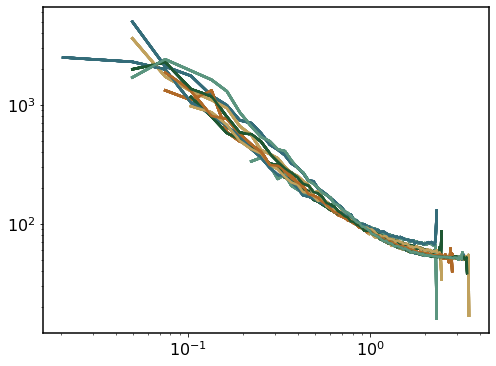

In [10]:
for i in range(CO.Nmu):
    plt.loglog(CO.k_Pk_poles, CO.Pk_2d.power['power'].real)

In [26]:
m.nuObs

<Quantity 32.93457143 GHz>

In [29]:
m.Delta_nu

<Quantity 1.88351307 GHz>

In [27]:
CO.nuObs_min

<Quantity 32.01972222 GHz>

In [28]:
CO.nuObs_max

<Quantity 33.90323529 GHz>

In [6]:
Pnoise=m.Pnoise

Note: redshifts have been re-sorted (earliest first)


(1.0, 1000000.0)

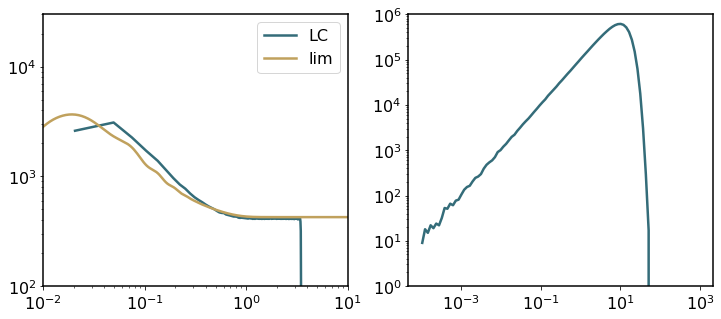

In [11]:
m.update(smooth=True, Tsys_NEFD=20*u.K, Delta_nu=20*u.GHz, Omega_field=1000*u.deg**2, sigma_NL=0.1*u.Mpc)
#CO.update(do_smooth=True, Tsys=20*u.K)

P0_lim=0.5*np.trapz(m.Pk+Pnoise,m.mu,axis=0)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(CO.k_Pk_poles, CO.Pk_0, label='LC')
plt.loglog(m.k.to(CO.Mpch**-1), P0_lim.to(CO.Mpch**3*CO.unit**2), label='lim')
plt.legend()
plt.xlim(1e-2, 10)
plt.ylim(1e2, 3e4)

plt.subplot(1,2,2)
plt.loglog(CO.Ti, CO.Bi_VID)
#plt.loglog(m.Ti, m.Bi)
plt.ylim(1e0, 1e6)

(1.0, 1000000.0)

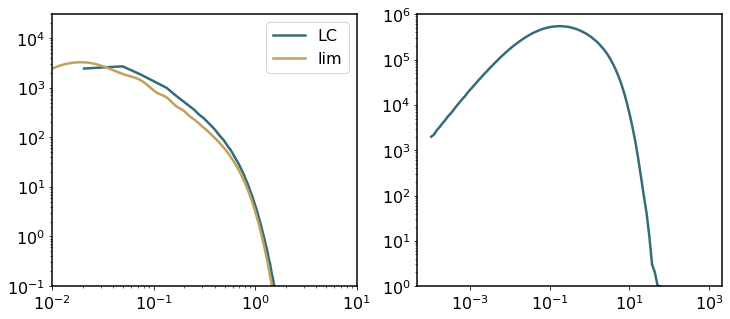

In [9]:
m.update(smooth=True, Tsys_NEFD=0*u.K, Delta_nu=20*u.GHz, Omega_field=1000*u.deg**2, sigma_NL=3*u.Mpc)
#CO.update(do_smooth=True, Tsys=0*u.K)

plt.figure(figsize=(12,5))
h=m.hubble
plt.subplot(1,2,1)
plt.loglog(CO.k_Pk_poles, CO.Pk_0, label='LC')
plt.loglog(m.k.to(CO.Mpch**-1), m.Pk_0.to(CO.Mpch**3*CO.unit**2), label='lim')
plt.legend()
plt.xlim(1e-2, 10)
plt.ylim(1e-1, 3e4)

plt.subplot(1,2,2)
plt.loglog(CO.Ti, CO.Bi_VID)
#plt.loglog(m.Ti, m.Bi)
plt.ylim(1e0, 1e6)

In [24]:
CO.Npix*CO.Nchan

15077689

In [25]:
m.Nvox

<Quantity 15077689.>

# SFR shenanigans

### Rewrite Nick's SFR table to convert $M_{\odot}/h \rightarrow M_{\odot}$

This file (UM) should have units of $[M] = M_{\odot}/h$, while the Behroozi file should have units of $[M] = M_{\odot}$. However, they match in the low halo mass regime, indicating that the Behroozi file is in fact in units of $[M] = M_{\odot}/h$!

In [30]:
UMfile=np.loadtxt('/home/gsatopolito/preLIMinary/SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean.dat')

zb = np.unique(UMfile[:,0])-1.
logMb = np.unique(UMfile[:,1])
logSFRb = UMfile[:,2].reshape(len(zb),len(logMb),order='F')
logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)

logM=np.log10(np.logspace(10, 13.5, 100))
z=2.45
UMSFR = np.zeros(logM.size)
for ii in range(0,logM.size):
    UMSFR[ii] = logSFR_interp(logM[ii],z)

In [31]:
#writing new UM file in units of Msun
correctedUMfile=UMfile[:,:]
correctedUMfile[:,1]=correctedUMfile[:,1] - np.log10(h)
np.savetxt('/home/gsatopolito/preLIMinary/SFR_tables/sfr_table_normalmean_UniverseMachine_medianFalse_clean_solMass.dat', correctedUMfile)

In [31]:
behroozifile=np.loadtxt('/home/gsatopolito/preLIMinary/SFR_tables/sfr_table_Behroozi.dat')

zb = np.unique(behroozifile[:,0])-1.
logMb = np.unique(behroozifile[:,1])
logSFRb = behroozifile[:,2].reshape(len(zb),len(logMb),order='F')
logSFR_interp = interp2d(logMb,zb,logSFRb,bounds_error=False,fill_value=-40.)

behrooziSFR = np.zeros(logM.size)
for ii in range(0,logM.size):
    behrooziSFR[ii] = logSFR_interp(logM[ii],z)

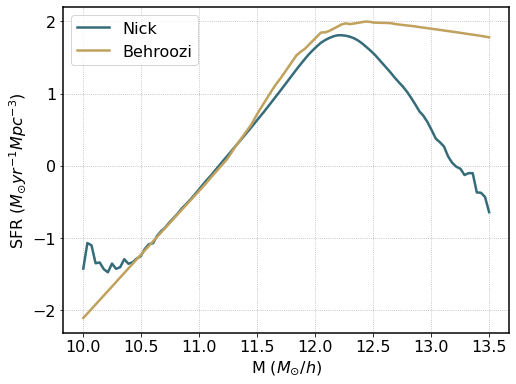

In [32]:
h=0.678
plt.plot(logM, UMSFR, label="Nick")
plt.plot(logM, behrooziSFR, label='Behroozi')
plt.xlabel('M ($M_{\odot}/h$)')
plt.ylabel('SFR ($M_{\odot} yr^{-1} Mpc^{-3}$)')
plt.legend()
plt.grid(linestyle='dotted')
plt.savefig('SFR_comparison.png', dpi=300)

### Checking $\sigma_{SFR}$ and $\sigma_{L_{CO}}$

In [46]:
delta_mf=CO.models['CO']['model_pars']['delta_mf']
alpha=CO.models['CO']['model_pars']['alpha']
beta=CO.models['CO']['model_pars']['beta']
sigma_LCO=CO.models['CO']['model_pars']['sigma_LCO']

logMcat=np.log10(CO.halo_catalog['M_HALO']*CO.Msunh.to(u.Msun).value)
SFRcat=CO.halo_catalog['SFR_HALO']

logM=np.linspace(np.min(logMcat), np.max(logMcat), 50)
sigSFR=[]
meanSFR=[]
meanLCO=[]
Nhalos=[]
for i in range(len(logM)-1):
    logSFRbin=np.log10(SFRcat[(logMcat>=logM[i])&(logMcat<logM[i+1])&(SFRcat>0)])
    sigSFR.append(np.std(logSFRbin))
    meanSFR.append(np.mean(logSFRbin))
    Nhalos.append(len(logSFRbin))
    
    LIR = 1e10 * 10**logSFRbin/delta_mf
    log10_LCO = (np.log10(LIR) - beta)/alpha
    sigma_base_e = sigma_LCO*2.302585
    LCO_samples = 10**(log10_LCO)*np.random.lognormal(-0.5*sigma_base_e**2, sigma_base_e, log10_LCO.shape)
    LCO= LCO_samples*4.9e-5*u.Lsun
    meanLCO.append(np.mean(LCO.value))
    
sigSFR=np.asarray(sigSFR)
meanSFR=np.asarray(meanSFR)
Nhalos=np.asarray(Nhalos)

(1000000.0, 13182567385.564047)

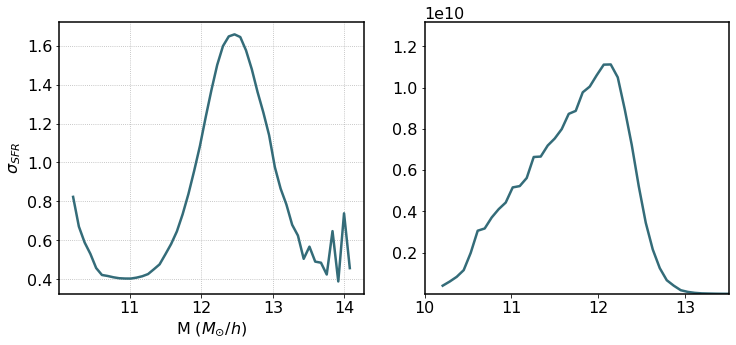

In [62]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(logM[:-1]+np.diff(logM)[0]/2, sigSFR)
plt.ylabel('$\sigma_{SFR}$')
plt.xlabel('M ($M_{\odot}/h$)')
plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.plot(logM[:-1]+np.diff(logM)[0]/2, Nhalos*meanLCO)
plt.xlim(10, 13.5)
plt.ylim(1e6, 10**10.12)
#plt.yscale('log')

In [67]:
weightedSFR=np.average(sigSFR, weights=Nhalos*meanLCO)

In [68]:
weightedSFR

0.906519312974405

### Halo mass function

In [23]:
#halos within footprint
inds_RA = (CO.halo_catalog['RA'] > CO.RAObs_min.value)&(CO.halo_catalog['RA'] < CO.RAObs_max.value)
inds_DEC = (CO.halo_catalog['DEC'] > CO.DECObs_min.value)&(CO.halo_catalog['DEC'] < CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (CO.nuObs_line_halo['CO'] >= CO.nuObs_min)&(CO.nuObs_line_halo['CO'] <= CO.nuObs_max)&inds_sky
M_in_survey = CO.halo_catalog['M_HALO'][inds]*CO.Msunh.to(u.Msun).value

logMcat=np.log10(M_in_survey)
logM=np.linspace(np.min(logMcat), np.max(logMcat), 50)
Nhalos, _=np.histogram(logMcat, bins=logM)
dndM=Nhalos/np.diff(logM)[0]/((CO.Lbox[0]*CO.Lbox[1]*CO.Lbox[2]).to(u.Mpc**3))

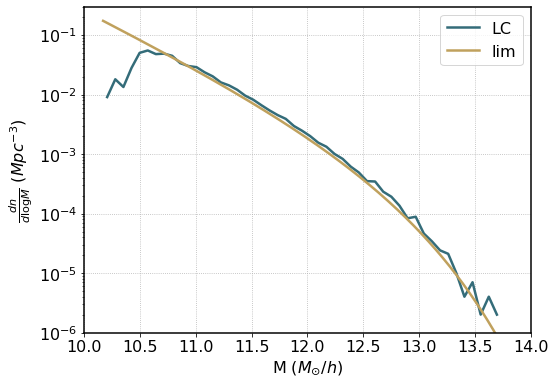

In [28]:
plt.plot(logM[:-1]+np.diff(logM)[0]/2, dndM, label='LC')
plt.plot(np.log10(m.M.value), np.log(10)*m.M.value*m.dndM, label='lim')
plt.yscale('log')
plt.ylim(1e-6,0.3)
plt.xlim(10, 14)
plt.xlabel('M ($M_{\odot}/h$)')
plt.ylabel(r'$\frac{dn}{d\log M}$ ($Mpc^{-3}$)')
plt.legend()
plt.grid(linestyle='dotted')
plt.savefig('Mass_function.png', dpi=300)

### Custom SFR functions

\begin{equation}
\text{SFR}(M) = M_0 \left(\frac{M}{M_a}\right)^a\left[1+ \left(\frac{M}{M_b}\right)^b\right]^c
\end{equation}

For the Universe Machine SFR:
\begin{equation}
\begin{split}
M_0 &=10^{-6} \\
M_a &=10^8 \\
M_b &=10^{12.3} \\
a &=1.9 \\
b &=3 \\
c &=-1.4
\end{split}
\end{equation}

For Behroozi SFR:
\begin{equation}
\begin{split}
M_0 &=10^{-6} \\
M_a &=10^8 \\
M_b &=10^{12.25} \\
a &=1.9 \\
b &=3 \\
c &=-0.71
\end{split}
\end{equation}

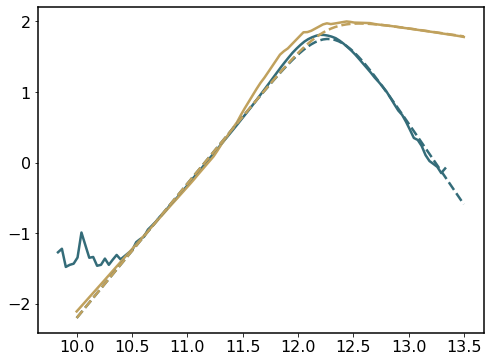

In [28]:
h=0.678
M=10**(logM)
M0_UM=10**-6
Ma_UM=10**8
Mb_UM=10**12.3
a_UM=1.9
b_UM=3
c_UM=-1.4
SFR_func_UM=M0_UM*((M/Ma_UM)**a_UM)*(1+(M/Mb_UM)**b_UM)**c_UM

M0_brz=10**-6
Ma_brz=10**8
Mb_brz=10**12.25
a_brz=1.9
b_brz=3
c_brz=-0.71
SFR_func_brz=M0_brz*((M/Ma_brz)**a_brz)*(1+(M/Mb_brz)**b_brz)**c_brz

plt.plot(logM+np.log10(h), UMSFR)
plt.plot(logM, behrooziSFR)
plt.plot(logM, np.log10(SFR_func_UM), 'C0--')
plt.plot(logM, np.log10(SFR_func_brz), 'C1--')

In [5]:
CO_behrooziSFR = make_survey(LC_params(True, 'Behroozi_SFR', 20))
CO_UMSFR = make_survey(LC_params(True, 'UniverseMachine_SFR', 20))

/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


/home/gsatopolito/preLIMinary/source/lightcone.py:185: RuntimeWarning: divide by zero encountered in log10
  SFR = 10**(np.random.normal(np.log10(SFR), self.sig_extSFR))
/home/gsatopolito/preLIMinary/source/line_models.py:34: RuntimeWarning: divide by zero encountered in log10
  log10_LCO = (np.log10(LIR) - beta)/alpha


/home/gsatopolito/JHU/Research/LC files/lightcone_MDPL2UM_242.fits


### Observables with custom SFRs

In [4]:
model1=dict(M0=1e-6, Ma=10**8, Mb=10**12.3, a=1.9, b=3.0, c=-1.4)
CO1 = make_measurements(LC_params(True, 'Custom_SFR', model1, 20))

model2=dict(M0=1e-6, Ma=10**8, Mb=10**12.25, a=1.9, b=3.0, c=-0.71)
CO2 = make_measurements(LC_params(True, 'Custom_SFR', model2, 20))

/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_158.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_159.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_160.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_161.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_162.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_163.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_164.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_158.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_159.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_160.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_161.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_162.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_163.fits
/home/gsatopolito/JHU/Research/SQLC files/lightcone_MDPL2UM_164.fits


In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(CO1.k_Pk_poles, CO1.Pk_0, label='Model 1')
plt.loglog(CO2.k_Pk_poles, CO2.Pk_0, label='Model 2')
plt.loglog(CO2.k_Pk_poles[1:], np.sqrt(CO2.covmat_00), 'C1--')
plt.legend()
plt.xlim(1e-2, 10)
plt.ylim(1e1, 3e4)

plt.subplot(1,2,2)
plt.loglog(CO1.Ti, CO1.Bi_VID)
plt.loglog(CO2.Ti, CO2.Bi_VID)
plt.ylim(1e0, 1e6)

Note: redshifts have been re-sorted (earliest first)


(1.0, 1000000.0)

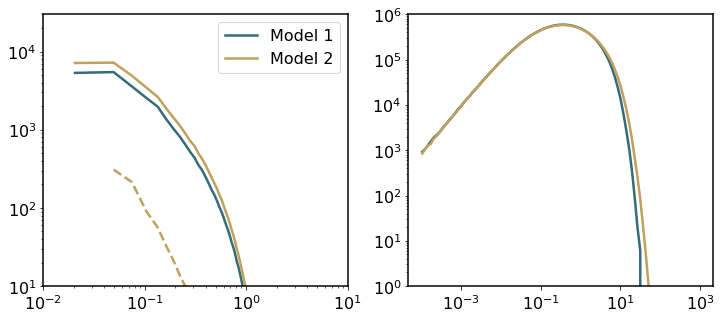

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(CO1.k_Pk_poles, CO1.Pk_0, label='Model 1')
plt.loglog(CO2.k_Pk_poles, CO2.Pk_0, label='Model 2')
plt.loglog(CO2.k_Pk_poles[1:], np.sqrt(CO2.covmat_00), 'C1--')
plt.legend()
plt.xlim(1e-2, 10)
plt.ylim(1e1, 3e4)

plt.subplot(1,2,2)
plt.loglog(CO1.Ti, CO1.Bi_VID)
plt.loglog(CO2.Ti, CO2.Bi_VID)
plt.ylim(1e0, 1e6)